In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import tushare as ts
import torch
from torch import nn
import datetime
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
DAYS_FOR_TRAIN = 24

In [3]:
class LSTM_Regression(nn.Module):
    """ 
        parameters:
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid=nn.Sigmoid()

    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        x = self.fc(x)
        x = x.view(s, b)  
        x=self.sigmoid(x)
        return x


In [4]:
def create_dataset(data, steps_for_train=DAYS_FOR_TRAIN) -> (np.array, np.array):
    dataset_x,dataset_y=[],[]
    for i in range(len(data)-steps_for_train):
        _x = data[i:(i+steps_for_train)]
        _y=data[(i+1):(i+steps_for_train+1),2]
        dataset_x.append(_x)
        dataset_y.append(_y)
    return (np.array(dataset_x), np.array(dataset_y))

In [5]:
def get_acc(y_true,y_pred):
    suc,sum=0,0
    y_diff=y_true-y_pred
    for line in y_diff:
        for elem in line:
            if(abs(elem)<0.5):
                suc=suc+1
            sum=sum+1
    return suc/sum

def get_auc(y_true,y_pred):
    y_pred=y_pred.detach().numpy()
    y_pred=y_pred.reshape(-1)
    y_true=y_true.reshape(-1)
    arrIndex=np.array(y_pred).argsort()
    y_pred=y_pred[arrIndex]
    y_true=y_true[arrIndex]
    
    return metrics.roc_auc_score(y_true,y_pred)
    

In [6]:
all_x,all_y=np.zeros((0,DAYS_FOR_TRAIN,26)),np.zeros((0,DAYS_FOR_TRAIN))
train_x,train_y,test_x,test_y=[],[],[],[]
one_match_x,one_match_y=[],[]
opponent_x,opponent_x=[],[]

In [7]:
csv_data=pandas.read_csv("./C_Wimbledon_featured_matches.csv")
all_pair=[]
for i in range(len(csv_data)):
    new_pair=[csv_data['player1'][i],csv_data['player2'][i]]
    if new_pair not in all_pair:
        all_pair.append(new_pair)
for i in range(len(all_pair)):
    csv_temp=csv_data[csv_data['player1']==all_pair[i][0]]
    csv_temp=csv_temp[csv_temp['player2']==all_pair[i][1]]
    list_temp=csv_temp.values.tolist()
    list_temp=np.array(list_temp)
    list_temp=list_temp[:,(7,8,13,14,15,18,19,20,21,22,23,25,26,27,28,33,34,35,36,37,38)]
    leng=len(list_temp)
    apd=np.zeros((leng,7),dtype=float)
    list_temp=np.concatenate((list_temp,apd),axis=1)
    list_temp=list_temp.astype(np.float32)
    for line in list_temp:
        line[0]/=2
        line[1]/=2
        if line[2]==1:
            if line[3]==1:
                line[21]=1
            else:
                line[22]=1
        else:
            if line[3]==1:
                line[23]=1
            else:
                line[24]=1
        if line[4]==2:
            line[4]=0
            line[25]=1
        if line[5]==2:
            line[5]=0
            line[26]=1
        if line[6]==2:
            line[6]=0
            line[27]=1
    if i==0:
        another_list=list_temp[:,(1,0,25,4,26,5,27,6,8,7,10,9,12,11,14,13,16,15,18,17,20,19,23,24,21,22)]
    list_temp=list_temp[:,(0,1,4,25,5,26,6,27,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24)]
    x0,y0=create_dataset(list_temp)
    all_x=np.concatenate((all_x,x0))
    all_y=np.concatenate((all_y,y0))
    if i==0:
        one_match_x=x0
        one_match_y=y0
        opponent_x,opponent_y=create_dataset(another_list)




        
        
    


In [8]:
if __name__ == '__main__':
    train_x,test_x,train_y,test_y=train_test_split(all_x, all_y, test_size=0.2, shuffle=False)
    train_x=train_x.transpose(1,0,2)
    train_y=train_y.transpose(1,0)
    test_x=test_x.transpose(1,0,2)
    test_y=test_y.transpose(1,0)
    train_x=torch.from_numpy(train_x).float()
    train_y=torch.from_numpy(train_y).float()
    test_x=torch.from_numpy(test_x).float()
    test_y=torch.from_numpy(test_y).float()
    t0 = time.time()
    print(np.shape(train_y))
    one_dimension_y=train_y[23,:]

    model = LSTM_Regression(26, 28, output_size=1, num_layers=2) 



    train_loss ,train_acc,train_auc= [],[],[]
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    for i in range(250):
        out = model.forward(train_x)
        loss = loss_function(out, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())
        #train_acc.append(get_acc(train_y,out))
        #train_auc.append(get_auc(one_dimension_y,out[23,:]))
        
        with open('log.txt', 'a+') as f:
            f.write('{} - {}\n'.format(i+1, loss.item()))
        if (i+1) % 1 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(i+1, loss.item()))

    
    plt.figure()
    plt.plot(train_loss, 'b', label='loss')
    plt.title("Train_Loss_Curve")
    plt.ylabel('train_loss')
    plt.xlabel('epoch_num')
    plt.savefig('loss.png', format='png', dpi=200)
    plt.close()
    

    plt.figure()
    plt.plot(train_acc,'r',label='acc')
    plt.plot(train_auc,'b',label='auc')
    plt.legend(loc="right")
    plt.title("Train_Evaluation_metrics_Curve")
    plt.ylabel('train_acc/auc')
    plt.xlabel('epoch_num')
    plt.savefig('metric.png',format='png',dpi=200)
    plt.close()
    
    
    torch.save(model.state_dict(), 'model_params.pkl')  
    t1=time.time()
    T=t1-t0
    print('The training time took %.2f'%(T/60)+' mins.')

    tt0=time.asctime(time.localtime(t0))
    tt1=time.asctime(time.localtime(t1))
    print('The starting time was ',tt0)
    print('The finishing time was ',tt1)


    # for test
    model = model.eval() 

    pred_test = model(test_x) 
    loss=loss_function(pred_test,test_y)
    print(loss.item())
    
    acc=get_acc(test_y,pred_test)
    print('acc=',acc)

    auc=get_auc(test_y,pred_test)
    print('auc=',auc)
    
    


torch.Size([24, 5232])
Epoch: 1, Loss:0.69343
Epoch: 2, Loss:0.69348
Epoch: 3, Loss:0.69197
Epoch: 4, Loss:0.69132
Epoch: 5, Loss:0.69035
Epoch: 6, Loss:0.68829
Epoch: 7, Loss:0.68523
Epoch: 8, Loss:0.68138
Epoch: 9, Loss:0.67544
Epoch: 10, Loss:0.66839
Epoch: 11, Loss:0.66438
Epoch: 12, Loss:0.66502
Epoch: 13, Loss:0.66300
Epoch: 14, Loss:0.65867
Epoch: 15, Loss:0.65487
Epoch: 16, Loss:0.65275
Epoch: 17, Loss:0.65199
Epoch: 18, Loss:0.65124
Epoch: 19, Loss:0.64970
Epoch: 20, Loss:0.64787
Epoch: 21, Loss:0.64633
Epoch: 22, Loss:0.64517
Epoch: 23, Loss:0.64427
Epoch: 24, Loss:0.64330
Epoch: 25, Loss:0.64190
Epoch: 26, Loss:0.64024
Epoch: 27, Loss:0.63857
Epoch: 28, Loss:0.63691
Epoch: 29, Loss:0.63554
Epoch: 30, Loss:0.63441
Epoch: 31, Loss:0.63317
Epoch: 32, Loss:0.63183
Epoch: 33, Loss:0.63044
Epoch: 34, Loss:0.62945
Epoch: 35, Loss:0.62879
Epoch: 36, Loss:0.62845
Epoch: 37, Loss:0.62807
Epoch: 38, Loss:0.62739
Epoch: 39, Loss:0.62649
Epoch: 40, Loss:0.62565
Epoch: 41, Loss:0.62509
Ep

In [9]:

one_match_x=one_match_x.transpose(1,0,2)
one_match_x=torch.from_numpy(one_match_x).float()
opponent_x=opponent_x.transpose(1,0,2)
opponent_x=torch.from_numpy(opponent_x).float()


In [10]:
one_match_pred=model(one_match_x)
opponent_pred=model(opponent_x)
one_match_pred=one_match_pred.detach().numpy()
one_match_pred=one_match_pred[23,:]
opponent_pred=opponent_pred.detach().numpy()
opponent_pred=opponent_pred[23,:]
relative_ad=one_match_pred-opponent_pred
even_1,even_2=[],[]
for i in range(len(one_match_pred)-5):
    even_1.append(np.sum(one_match_pred[i:(i+5)]/5))
    even_2.append(np.sum(opponent_pred[i:(i+5)]/5))

plt.figure()
plt.plot(even_1, 'b', label='1-momentum')
plt.plot(even_2,'r',label='2-momentum')
plt.legend(loc="lower right")
plt.title("Momentum_Tendency")
plt.ylabel('momentum')
plt.xlabel('time')
plt.savefig('momentum.png', format='png', dpi=200)
plt.close()

plt.figure()
plt.axhline(0, color='black', linestyle='--')
plt.plot(relative_ad,'b',label='relative advantage')
plt.title("Relative_Advantage")
plt.ylabel('relative advantage')
plt.xlabel('time')
plt.savefig('relative.png', format='png', dpi=200)
plt.close()

'''
arrIndex=np.array(one_match_pred).argsort()
one_match_pred=one_match_pred[arrIndex]
opponent_pred=opponent_pred[arrIndex]
plt.figure()
plt.plot(one_match_pred, 'b', label='1-momentum')
plt.plot(opponent_pred,'r',label='2-momentum')
plt.legend(loc="lower right")
plt.title("Momentum_Coherence")
plt.ylabel('momentum')
plt.xlabel('case')
plt.savefig('momentum.png', format='png', dpi=200)
plt.close()
'''

swing=np.zeros((272,1),dtype=float)
one_match_x=one_match_x.detach().numpy()
for i in range(271):
    if relative_ad[i]*relative_ad[i+1]<=0:
        swing[i+1]=1
    else:
        swing[i+1]=0



(24, 276, 26)


c:\Users\15165\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\15165\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


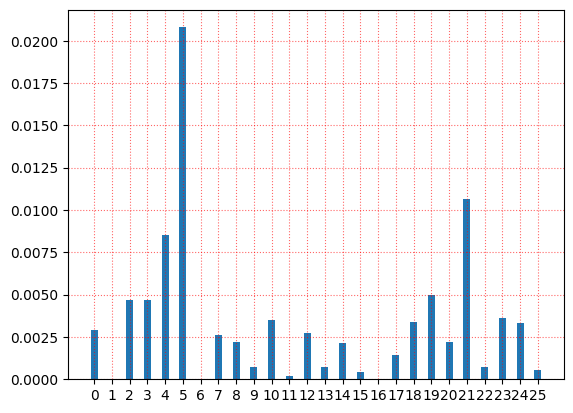

In [11]:
print(np.shape(one_match_x))
cut_x=one_match_x[23,0:272,:]
swing=swing.reshape(-1)
x,y=[],[]
for i in range(26):
    oneline=cut_x[:,i]
    oneline=oneline.reshape(-1)
    y.append(metrics.mutual_info_score(oneline,swing))
    x.append(2*i+1)
x_label=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25']


plt.xticks(x,x_label)
plt.bar(x, y)
plt.grid(True,linestyle=':',color='r',alpha=0.6)
plt.show()

